## Imports

In [32]:
import numpy as np

import torch

from matplotlib import pyplot as plt

import os
import sys

sys.path.append(os.path.abspath('..'))

plt.rcParams['text.usetex'] = True

from src.utils.data_utils import *
from src.utils.model_utils import *
from src.utils.plot_utils import *

from src.models.TurbulenceNetwork import *
from src.data_gens.TurbulenceClosureDataGenerator import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

formatter = lambda x, pos: f"{x:>6.3f}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## RMSE Loss

In [33]:
class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l

## Loading Reference Data

In [34]:
dim = 700
log = (-.5, 2)

x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model_prefix = ""
gp_extra = model_prefix + "GP_chpc/"

## Loading Ensemble, MC-Dropout, and SVI results

In [36]:
ensemble_pred = np.nan_to_num(np.loadtxt("../data/Ensemble/" + model_prefix + "Pred_Mean.csv", delimiter=","), nan=0)
ensemble_std = np.nan_to_num(np.loadtxt("../data/Ensemble/" + model_prefix + "Pred_Std.csv", delimiter=","), nan=0)

mcd_pred = np.nan_to_num(np.loadtxt("../data/MCD/" + model_prefix + "Pred_Mean.csv", delimiter=","), nan=0)
mcd_std = np.nan_to_num(np.loadtxt("../data/MCD/" + model_prefix + "Pred_Std.csv", delimiter=","), nan=0)

svi_pred = np.nan_to_num(np.loadtxt("../data/SVI/" + model_prefix + "Pred_Mean.csv", delimiter=","), nan=0)
svi_std = np.nan_to_num(np.loadtxt("../data/SVI/" + model_prefix + "Pred_Std.csv", delimiter=","), nan=0)

gp_pred = np.nan_to_num(np.loadtxt("../data/GP/" + gp_extra + model_prefix + "Pred_Mean.csv", delimiter=","), nan=0)
gp_std = np.nan_to_num(np.loadtxt("../data/GP/" + gp_extra +  model_prefix + "Pred_Std.csv", delimiter=","), nan=0)

ensemble_std = ensemble_std.T.reshape(3, dim, dim)
mcd_std = mcd_std.T.reshape(3, dim, dim)
svi_std = svi_std.T.reshape(3, dim, dim)
gp_std = gp_std.T.reshape(3, dim, dim)

## Plotting Abs Difference 3x3

Ensemble RMSE Error: 0.00043085907461964555
MCD RMSE Error: 0.0012396261514755701
SVI RMSE Error: 0.003147906315262012
GP RMSE Error: 5.366824624975943e-07


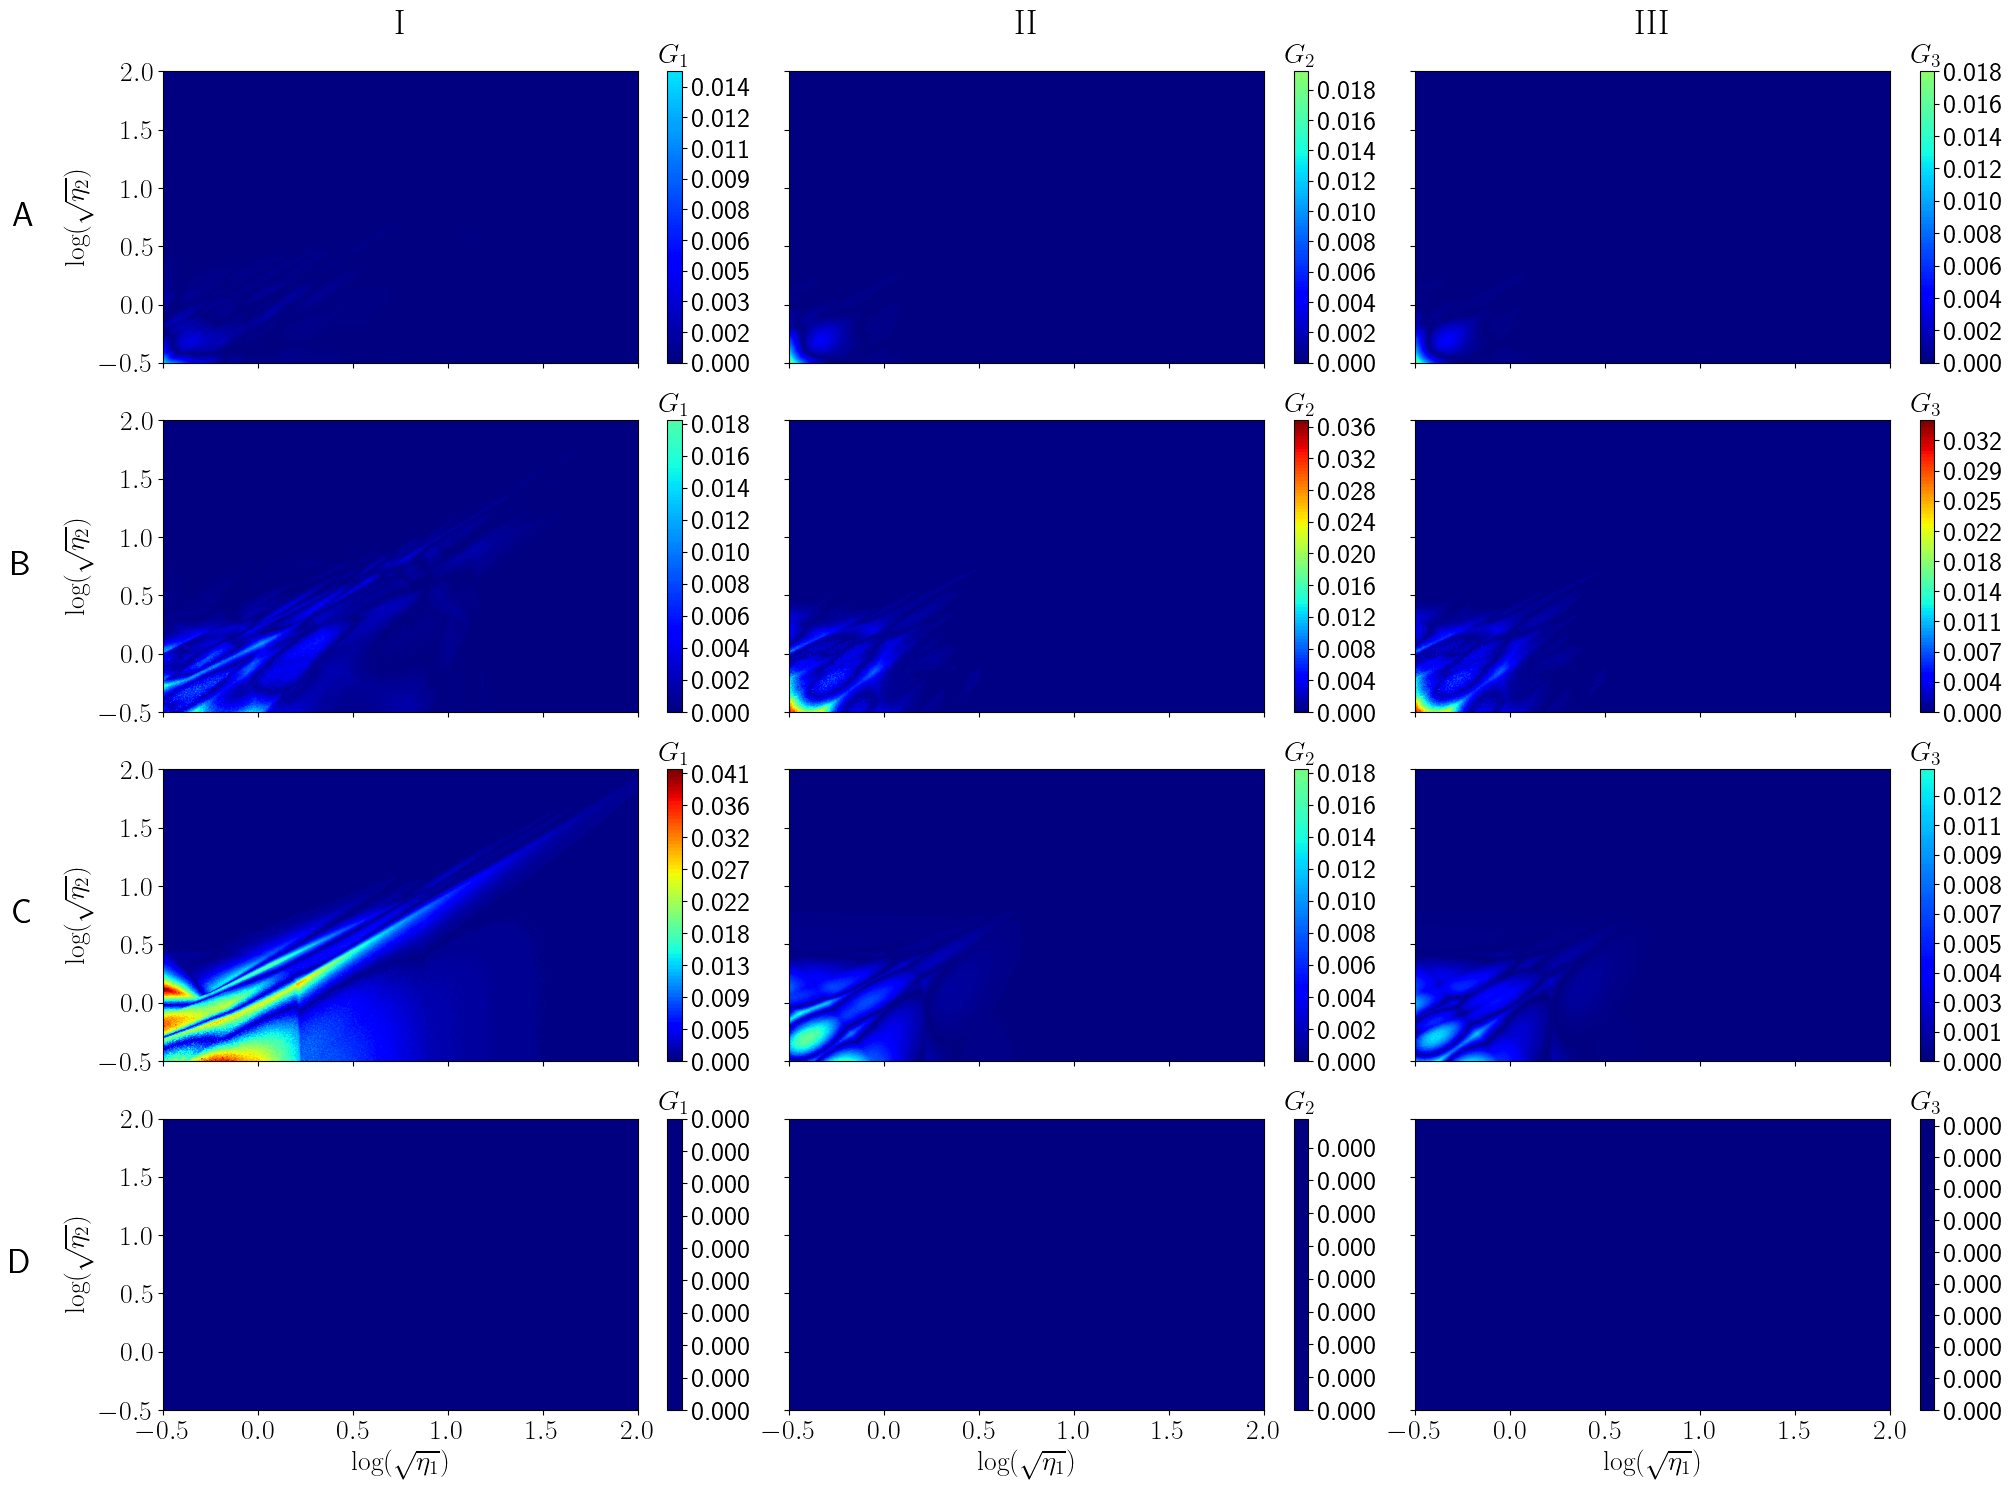

In [37]:
Error_Criterion = RMSELoss()

ensemble_error = np.abs(ensemble_pred - target)
mcd_error = np.abs(mcd_pred - target)
svi_error = np.abs(svi_pred - target)
gp_error = np.abs(gp_pred - target)

ensemble_error = ensemble_error.T.reshape(3, dim, dim)
mcd_error = mcd_error.T.reshape(3, dim, dim)
svi_error = svi_error.T.reshape(3, dim, dim)
gp_error = gp_error.T.reshape(3, dim, dim)

ensemble_rmse_error = Error_Criterion(torch.tensor(ensemble_pred), torch.tensor(target)).item()
mcd_rmse_error = Error_Criterion(torch.tensor(mcd_pred), torch.tensor(target)).item()
svi_rmse_error = Error_Criterion(torch.tensor(svi_pred), torch.tensor(target)).item()
gp_rmse_error = Error_Criterion(torch.tensor(gp_pred), torch.tensor(target)).item()

print(f"Ensemble RMSE Error: {ensemble_rmse_error}")
print(f"MCD RMSE Error: {mcd_rmse_error}")
print(f"SVI RMSE Error: {svi_rmse_error}")
print(f"GP RMSE Error: {gp_rmse_error}")

row_titles = ["A", "B", "C", "D"]
col_titles = [r"$\mathrm{I}$", r"$\mathrm{II}$", r"$\mathrm{III}$", r"$\mathrm{IV}$"]

plot_grid(x_grid, y_grid, [ensemble_error, mcd_error, svi_error, gp_error], row_titles, col_titles, formatter, save_path="../Figures/Combined/" + model_prefix + "_Pred_Error.png")

## Plotting STD of Ensemble, MC-Dropout, and SVI

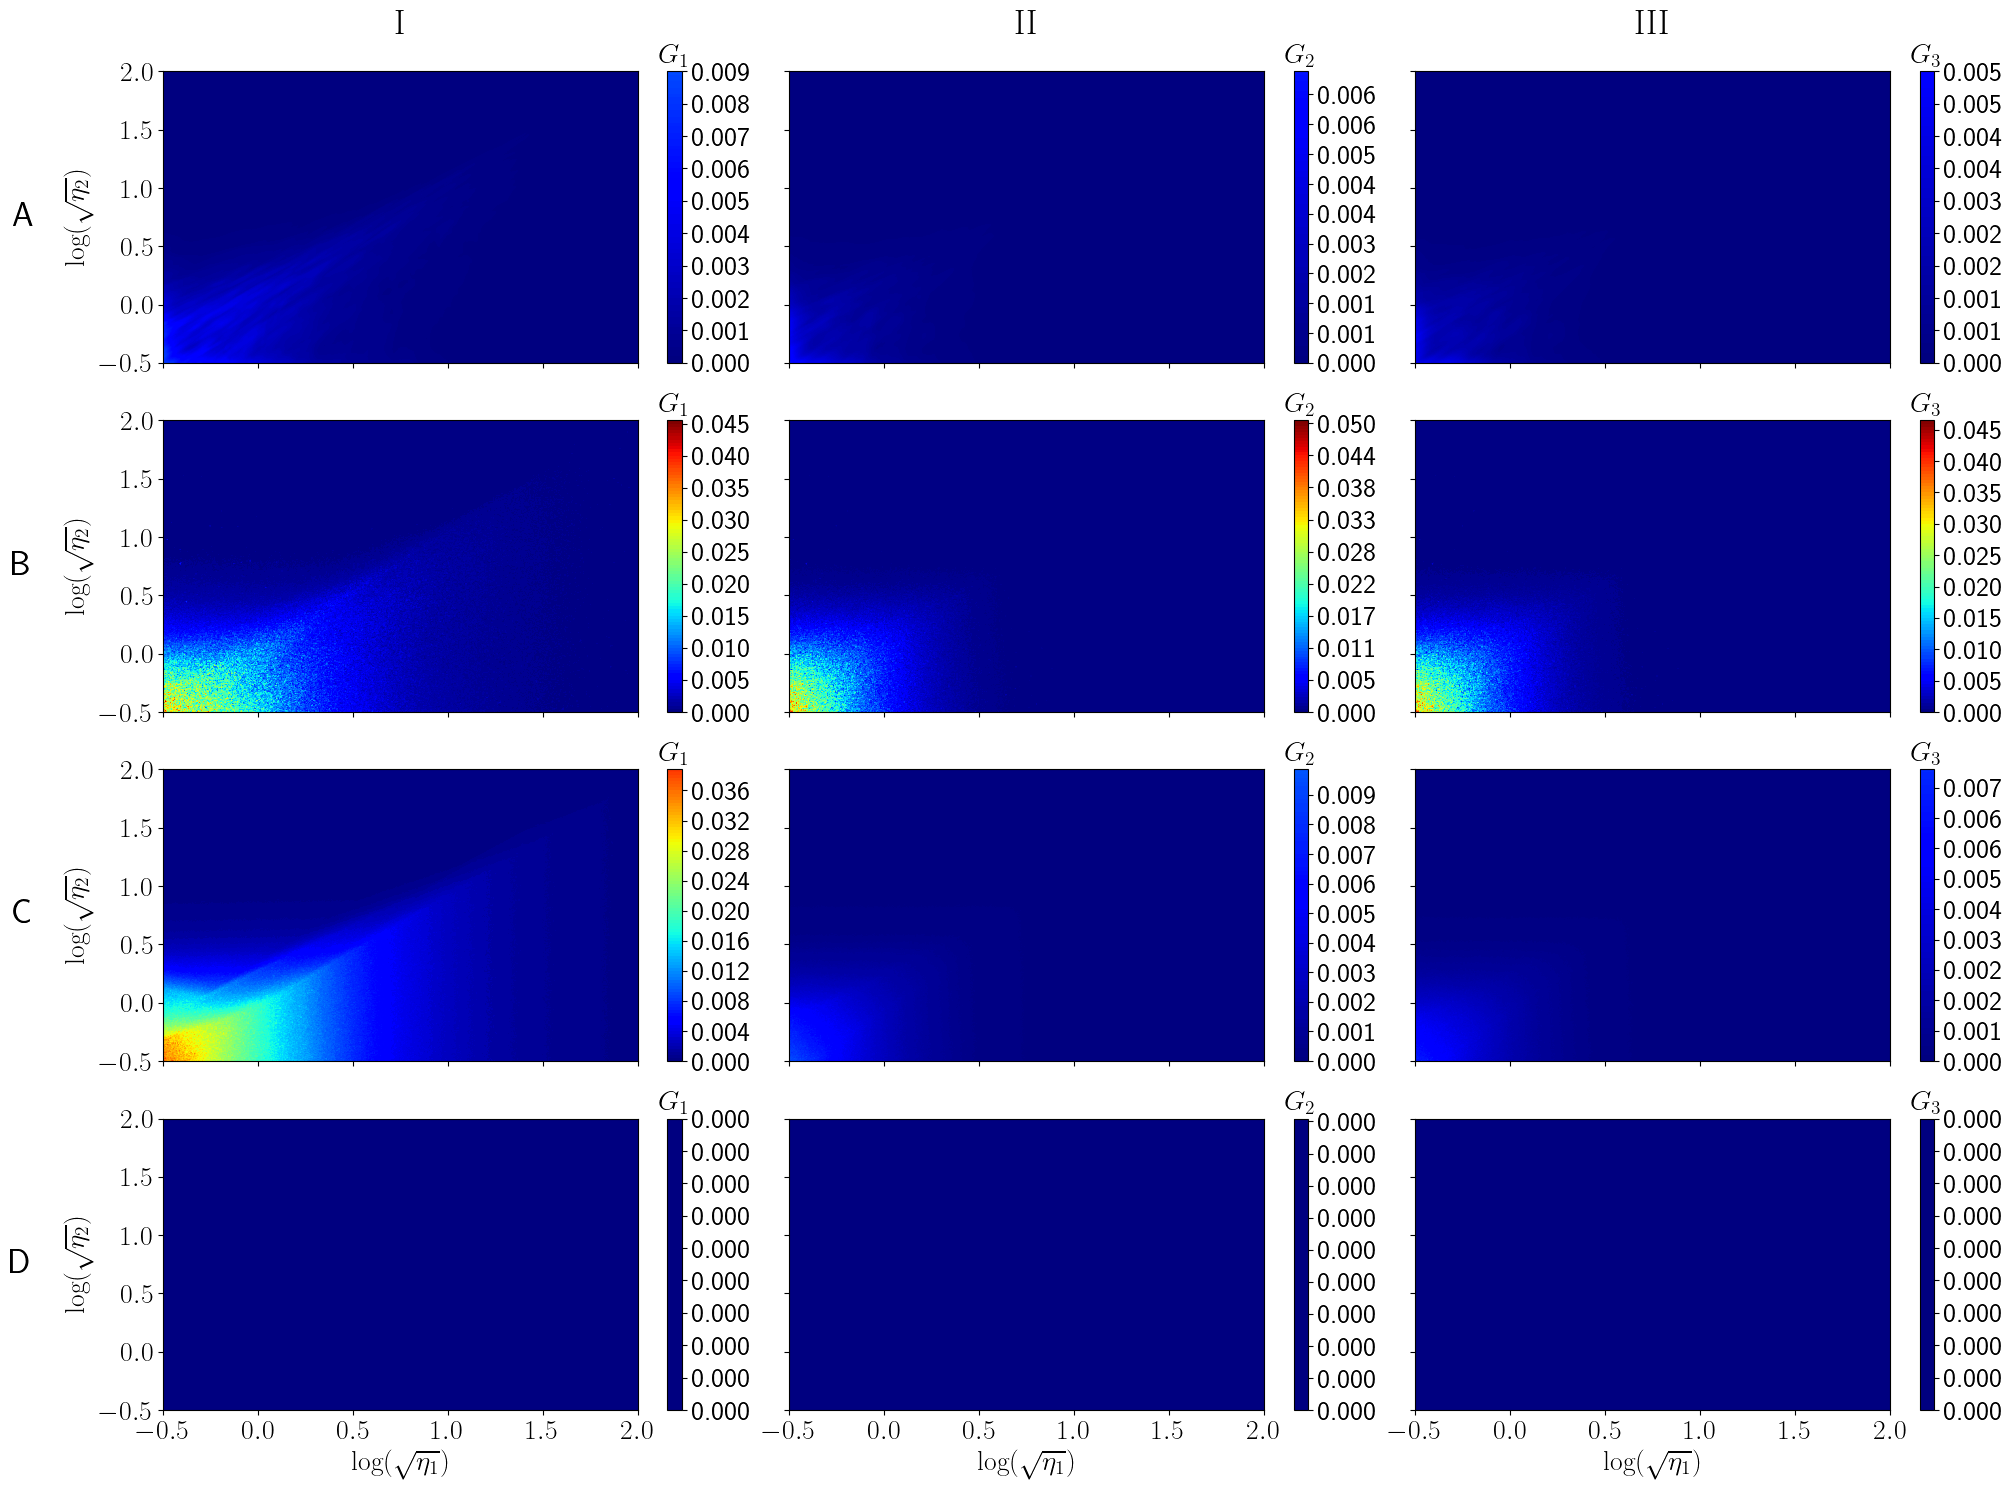

In [38]:
plot_grid(x_grid, y_grid, [ensemble_std, mcd_std, svi_std, gp_std], row_titles, col_titles, formatter, save_path="../Figures/Combined/" + model_prefix + "_Pred_STD.png")

### Generating data to get accurate scalers

In [ ]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_vis, gs_vis = generate_log_data(SSG_gen, log, 900, shuffle=True, gen_type="All")

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


### Function Visualization

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "./Model_Checkpoints/"

x_vis = torch.tensor(x_scaler.transform(etas_vis), dtype=torch.float32).to(device)
y_vis = torch.tensor(y_scaler.transform(gs_vis), dtype=torch.float32).to(device)

y_trans = y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1)

### Ensemble Predictions

In [ ]:
from skorch import NeuralNetRegressor

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 1e-6,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "verbose": 0,
}

num_members = 40

ens_dir = "ensemble/"
ensemble = []

for i in range(num_members):
    net = reinitialize_model(f'TurbulenceNetwork_Ens_{i}.pt', checkpoint_dir+ens_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)

ens_predictions = []
for member in ensemble:
    ens_predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

ens_predictions = np.concatenate(ens_predictions, axis=0)

ens_error = np.abs(ens_predictions - y_trans)
print(f"Ensemble Error: {np.mean(ens_error)}")


Ensemble Error: 0.00034297831007279456


### MC-Dropout Predictions

In [ ]:
names = ['TurbulenceNetwork_MCD1.pt', 'TurbulenceNetwork_MCD2.pt', 'TurbulenceNetwork_MCD3.pt', 'TurbulenceNetwork_MCD4.pt']

mcd_dir = "MCD/"

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
        "dropout": [0.001, 0.001, 0.001],
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        #"optimizer__weight_decay": 1e-7,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 1000,
        "device": device,
        "verbose": 0,
}


mcd_names = ['TurbulenceNetwork_MCD1.pt', 'TurbulenceNetwork_MCD2.pt', 'TurbulenceNetwork_MCD3.pt']

T = 100

mcd_predictions = []
mcd_labels = []

for i, name in enumerate(mcd_names):
    net = reinitialize_model(name, checkpoint_dir+mcd_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net.module.dropout_on()
    predictions = np.zeros((T, x_vis.shape[0], 3))
    for j in range(T):
        predictions[j] = y_scaler.inverse_transform(net.module(x_vis.to(device)).cpu().detach().numpy())
    mcd_predictions.append(predictions.reshape(T, -1))
    mcd_labels.append(i*np.ones(T))


mcd_predictions = np.concatenate(mcd_predictions, axis=0)
mcd_labels = np.concatenate(mcd_labels, axis=0)

error = np.abs(mcd_predictions - y_trans)

print(f"Mean error: {np.mean(error)}")

Mean error: 0.0005652618283853708


### SVI Predictions

In [ ]:
import pyro
from pyro.infer import Predictive

from pyro.infer.autoguide import AutoLowRankMultivariateNormal

model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "num_layers": 4,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device),
    "device": device,
    "output_prior": torch.tensor([.1], device=device)
}

svi_names = ['pyro1', "pyro2", 'pyro3']

svi_predictions = []
svi_labels = []

for i, chkpt in enumerate(svi_names):
    pyro.clear_param_store()
    model = TurbulenceNetworkBayesian(**model_params)
    model, guide = load_pyro_model(model, "Model_Checkpoints/SVI", device, chkpt_name=chkpt)
    predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("obs",))
    preds = predictive(x_vis)['obs'].detach().cpu()
    for j in range(preds.shape[0]):
        preds[j] = torch.tensor(y_scaler.inverse_transform(preds[j].numpy()))
    preds = preds.reshape(preds.shape[0], -1)
    svi_predictions.append(preds)
    svi_labels.append(np.ones(preds.shape[0])*i)

svi_predictions = torch.cat(svi_predictions, dim=0).numpy()
svi_labels = np.concatenate(svi_labels)


error = np.abs(svi_predictions - y_trans)
print(f"ERROR: {np.mean(error)}")

ERROR: 0.0012865480966866016


## PHATE

Calculating PHATE...
  Running PHATE on 641 observations and 2700 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 1.04 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.35 seconds.
Calculated PHATE in 1.41 seconds.


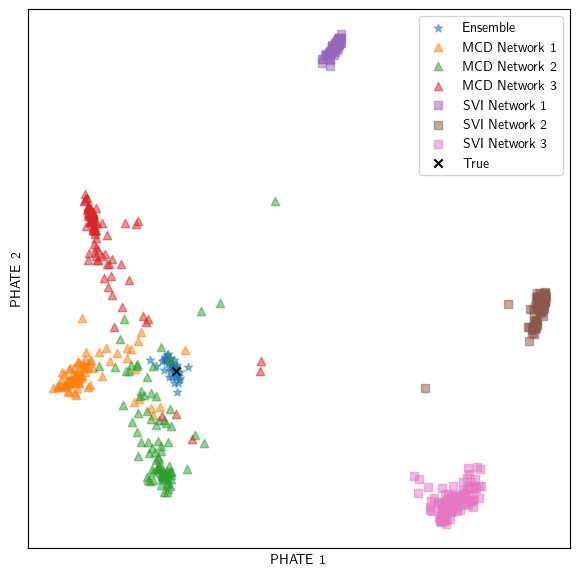

In [ ]:
from phate import PHATE

phate_input = np.concatenate([ens_predictions, mcd_predictions, svi_predictions, y_trans], axis=0)
phate_op = PHATE(n_components=2, n_jobs=5, knn=20, random_state=42, t=5, gamma=0)

phate_output = phate_op.fit_transform(phate_input)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))


## Ensemble
ax.scatter(phate_output[:ens_predictions.shape[0], 0], phate_output[:ens_predictions.shape[0], 1], label="Ensemble", marker='*', alpha=0.5)


## MCD
for i, name in enumerate(mcd_names):
    indices = np.where(mcd_labels == i)[0] + ens_predictions.shape[0]
    plt.scatter(phate_output[indices, 0], phate_output[indices, 1], label=f"MCD Network {i+1}", marker='^', alpha=0.5)

## SVI
for i, name in enumerate(svi_names):
    indices = np.where(svi_labels == i)[0] + ens_predictions.shape[0] + mcd_predictions.shape[0]
    plt.scatter(phate_output[indices, 0], phate_output[indices, 1], label=f"SVI Network {i+1}", marker='s', alpha=0.5)

plt.scatter(phate_output[-1, 0], phate_output[-1, 1], label="True", c='black', marker='x')


plt.xlabel("PHATE 1")
plt.xticks([])

plt.ylabel("PHATE 2")
plt.yticks([])


plt.legend()
plt.savefig("Figures/Combined/PHATE_Prediction.png")
plt.show()